<a href="https://colab.research.google.com/github/fbeneventi/public-notebooks/blob/main/examon_data_catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ExaMon Data Catalog

This notebook attempts to define an inventory of the data within the ExaMon database and more importantly wants to show how to use the API to build and extend it.

The procedures shown below focus on data related to the Marconi 100 system. These are mainly intended to show how to obtain, in a practical way, data information (metadata) from the database to efficiently create and document any dataset extracted from ExaMon.

**Status**: The notebook is a work in progress so questions and comments are welcome.

To obtain ExaMon credentials please contact:

- [Andrea Bartolini](mailto://a.bartolini@unibo.it)
- [Francesco Beneventi](mailto://francesco.beneventi@unibo.it)

**Please note:** by using your ExaMon account you are able to access data owned by CINECA and are therefore subject to the same privacy regulations that every CINECA user is required to follow.

In [ ]:
%matplotlib inline

# Mount Drive and install the examon-client
#
# Mounting Drive is an optional step but heavily suggested to have optimal
# performance in Google Colab

# (optional)
from google.colab import drive
drive.mount('/content/drive')
# Create and change to the Examon workspace folder (optional)
! mkdir -p /content/drive/MyDrive/examon_workdir
%cd /content/drive/MyDrive/examon_workdir

# Install (required)
! pip install https://github.com/fbeneventi/releases/releases/latest/download/examon-client.zip

### Examon setup

In [ ]:
# Init steps

%matplotlib inline

import os
import getpass
import numpy as np
import pandas as pd
from examon.examon import Client, ExamonQL

# Connect
USER = input('username:')
print('password:')
PWD = getpass.getpass()
ex = Client('examon.cineca.it', port='3002', user=USER, password=PWD, verbose=False, proxy=True)
print('Creating the local metadata cache (one-time task). Please wait ...')
sq = ExamonQL(ex)


# ExaMon Plugins
Plugins are components of ExaMon that collect or process data. Each plugin is specialized for a particular type of data or application. Consequently, in the case of collector-type plugins, they define a unique set of tags for the metrics exported to ExaMon.

The `plugin` tag found in each ExaMon data is simply a namespace that defines metrics that have the same attributes (set of tags). Wanting to see things from a relational db (RDBMS) perspective, we can consider the metrics equivalent to *tables* that, in the context of the plugin, share the same schema.

In conclusion, it should be always possible to collect data related to a given plugin in a normalized table having as columns the tag keys of the metrics it collects.

To get started using the data contained in the ExaMon db, one option is to analyze the different sets of metrics collected by the various plugins. It is possible to use the `plugin` tag to identify the different groups of metrics in the ExaMon db.

In [ ]:
df = sq.DESCRIBE(tag_key='plugin') \
    .execute()

display(df)

,tag values
0,ipmi_pub
1,confluent_pub
2,vertiv_pub
3,schneider_pub
4,pmu_pub
5,logics_pub
6,predictive_maintenance_pub
7,ganglia_pub
8,slurm_pub
9,nvidia_pub


**NOTE:** In this report, we focus only on plugins that collect data from the Marconi 100 cluster of Cineca. The inner details of the operation of each plugin are omitted in favor of the data description.

## Ganglia
The [Ganglia](http://ganglia.sourceforge.net/) plugin connects to the Ganglia server (gmond), collects and translates the data payload (XML) to the ExaMon data model.


In [ ]:
# Query of all metrics (a.k.a. tables) collected by the ganglia plugin

df = sq.DESCRIBE(tag_key='plugin', tag_value='ganglia_pub') \
    .execute()

display(df)

,name
0,Gpu0_app_clock_violation
1,Gpu0_bar1_free
2,Gpu0_bar1_total
3,Gpu0_bar1_used
4,Gpu0_base_clock_violation
...,...
1466,udp_outdatagrams
1467,vm_pgmajfault
1468,vm_pgpgin
1469,vm_pgpgout


In [ ]:
# Query of all attributes (keys and values) of a specific metric
#
# RDBMS analogy:
# tag key = table column name
# tag values = table column values

df = sq.DESCRIBE(metric='Gpu0_gpu_temp') \
    .execute()

display(df)

,name,tag key,tag values
0,Gpu0_gpu_temp,chnl,[data]
1,Gpu0_gpu_temp,cluster,[marconi100]
2,Gpu0_gpu_temp,gcluster,[MARCONI100]
3,Gpu0_gpu_temp,group,[gpu]
4,Gpu0_gpu_temp,node,"[login01, login02, login03, login04, login05, ..."
5,Gpu0_gpu_temp,org,[cineca]
6,Gpu0_gpu_temp,plugin,[ganglia_pub]
7,Gpu0_gpu_temp,rack,"[205, 206, 207, 208, 209, 210, 211, 212, 213, ..."
8,Gpu0_gpu_temp,slot,"[01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 1..."
9,Gpu0_gpu_temp,units,[Celsius]


Some tags that are specific to this plugin are:


*   `gcluster`: cluster where the Ganglia server is collecting the data
*   `group`: label used by Ganglia to define sets of similar metrics





In [ ]:
# All the possible values of a given tag key
#
# For example, we are interested in knowing all the possible "group"s of metric
# configured in the Ganglia instance

df = sq.DESCRIBE(tag_key='group') \
    .execute()

display(df)

,tag values
0,_
1,gpu
2,system
3,network
4,cpu
5,disk
6,diskstat
7,ssl
8,core
9,ipmi


In [ ]:
# ...and consequently the Ganglia metrics that belong to a specific group:

df = sq.DESCRIBE(tag_key='group', tag_value='gpu') \
    .execute()

display(df)

,name
0,Gpu0_board_limit_violation
1,Gpu0_current_clock_throttle_reasons
2,Gpu0_ecc_dbe_aggregate_total
3,Gpu0_ecc_dbe_volatile_total
4,Gpu0_ecc_sbe_aggregate_total
...,...
139,Gpu3_sm_clock
140,Gpu3_sync_boost_violation
141,Gpu3_thermal_violation
142,Gpu3_total_energy_consumption


## IPMI
The [IPMI](https://en.wikipedia.org/wiki/Intelligent_Platform_Management_Interface) plugin collects all the sensor data provided by the OOB management interface (BMC) of cluster nodes.


In [ ]:
# Query of all metrics collected by the IPMI plugin for all the clusters

df = sq.DESCRIBE(tag_key='plugin', tag_value='ipmi_pub') \
    .execute()

display(df)

,name
0,0_0
1,Ambient_Temp
2,Avg_Power
3,CMOS_Battery
4,CPU1_Temp
...,...
118,ps1_input_power
119,ps1_input_voltag
120,ps1_output_curre
121,ps1_output_volta


In [ ]:
# For example, if we only want to know metrics that relate to the ipmi collector of
# Marconi 100:

df = sq.DESCRIBE(tag_key='plugin', tag_value='ipmi_pub') \
    .DESCRIBE(tag_key='cluster', tag_value='marconi100') \
    .JOIN(how='inner') \
    .execute()

display(df)

,name
0,0_0
1,ambient
2,dimm0_temp
3,dimm10_temp
4,dimm11_temp
...,...
100,ps1_input_power
101,ps1_input_voltag
102,ps1_output_curre
103,ps1_output_volta


In [ ]:
# If you are not sure, to obtain the list of eligible "tag_value"s to use as
# "cluster" filter:

df = sq.DESCRIBE(tag_key='cluster') \
    .execute()

print('Eligible "cluster" tag values:')
display(df)

Eligible "cluster" tag values:


,tag values
0,marconi100
1,galileo
2,marconi
3,antarex
4,predmnt
5,galileo100
6,g100


In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='total_power') \
    .execute()

display(df)

,name,tag key,tag values
0,total_power,chnl,[data]
1,total_power,cluster,[marconi100]
2,total_power,node,"[login01, login02, login03, login04, r205n01, ..."
3,total_power,org,"[cineca, test]"
4,total_power,plugin,[ipmi_pub]
5,total_power,rack,"[205, 206, 207, 208, 209, 210, 211, 212, 213, ..."
6,total_power,slot,"[01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 1..."
7,total_power,units,[Watts]


**NOTE:** `rack` and `slot`, if defined, are convenience tags that are extracted from the hostname of the nodes, which is already collected in the `node` field.

## Nagios

This plugin interfaces with a [Nagios](https://www.nagios.org/) extension developed by CINECA called ["Hnagios"](https://prace-ri.eu/wp-content/uploads/Design_Development_and_Improvement_of_Nagios_System_Monitoring_for_Large_Clusters.pdf), collects and translates the data payload to the ExaMon data model.

In [ ]:
# Query of all metrics collected by the Nagios plugin for all the clusters

df = sq.DESCRIBE(tag_key='plugin', tag_value='nagios_pub') \
    .execute()

display(df)

,name
0,hostscheduleddowtimecomments
1,plugin_output
2,state


In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='plugin_output') \
    .execute()

display(df)

,name,tag key,tag values
0,plugin_output,chnl,[data]
1,plugin_output,cluster,"[galileo, marconi, marconi100]"
2,plugin_output,description,"[EFGW_cluster::status::availability, EFGW_clus..."
3,plugin_output,host_group,"[compute, compute,cincompute, containers, cumu..."
4,plugin_output,nagiosdrained,"[0, 1]"
5,plugin_output,node,"[comlab01, deepops, dgx01, dgx02, dgx03, dgxku..."
6,plugin_output,org,[cineca]
7,plugin_output,plugin,[nagios_pub]
8,plugin_output,rack,"[201, 202, 205, 206, 207, 208, 209, 210, 211, ..."
9,plugin_output,slot,"[01, 02, 03, 04, 05, 06, 07, 08, 09, 1, 10, 11..."


Some tags that are specific to this plugin are:


*   `description`: it is the name of the entity (HW/SW) that is currently monitored by Nagios. It is defined as a hierarchy using `::` as a separator.
*   `host_group`: label to define group of nodes sharing the same function.
*   `nagiosdrained`: flag indicating that the node on which the specific alarm occurred was drained (placed offline) manually by an operator.
*   `state`: number indicating the state of host or service when the event handler was run
  *   Host events:
      *   0=UP,1=DOWN,2=UNREACHABLE
  *   Service events:
      *   0=OK,1=WARNING,2=CRITICAL,3=UNKNOWN
*   `state_type`:
      *   0=SOFT,1=HARD








In [ ]:
# For example, we may be interested in all the entities monitored by nagios on
# marconi100 and only for the 'compute' nodes

ret = ex.query_metricstags('state', 'description', filt={'cluster':['marconi100'], 'host_group':['compute']})

display(pd.DataFrame(ret))

,0
0,alive::ping
1,batchs::client
2,batchs::client::state
3,batchs::manager::state
4,bmc::events
5,filesys::eurofusion::mount
6,filesys::local::avail
7,filesys::local::mount
8,memory::phys::total
9,net::ib::status


In [ ]:
# For example, we may be interested in which Marconi 100 nodes are included in a
# certain "host_group"

# 1) list M100 "host_group"s
ret = ex.query_metricstags('state', 'host_group', filt={'cluster':['marconi100']})

display(pd.DataFrame(ret))

,0
0,compute
1,containers
2,cumulus
3,dgx
4,ibl
5,ibs
6,"idmtest,compute"
7,login
8,"login,globus"
9,"logins,login"


In [ ]:
# 2) The "management" nodes of Marconi 100

ret = ex.query_metricstags('state', 'node', filt={'cluster':['marconi100'],'host_group':['management']})

display(pd.DataFrame(ret))

,0
0,master01


## Weather
This plugin collects all the weather data related to the Cineca facility location (Casalecchio di Reno) using an online open weather service  (https://openweathermap.org).

In [ ]:
# Query of all metrics collected by the Weather plugin

df = sq.DESCRIBE(tag_key='plugin', tag_value='weather_pub') \
    .execute()

display(df)

,name
0,clouds
1,dew_point
2,feels_like
3,humidity
4,pressure
5,temp
6,uvi
7,visibility
8,wind_deg
9,wind_speed


In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='clouds') \
    .execute()

display(df)

,name,tag key,tag values
0,clouds,chnl,[data]
1,clouds,facility,[casalecchio_di_reno]
2,clouds,org,[cineca]
3,clouds,plugin,[weather_pub]
4,clouds,provider,[openweathermap.org]
5,clouds,type,"[current, daily_forecast, hourly_forecast]"
6,clouds,units,[%]


The `type` tag specifies the type of the requested metric:
*   `current`: measured value
*   `(hourly/daily)_forecast`: forecast at different time granularity

## Slurm
The Slurm plugin (time series data) collects some aggragated data from the [Slurm Workload Manager](https://www.schedmd.com/) server of the Cineca clusters.

**NOTE:** it is a work in progress and may have some inconsistencies.


In [ ]:
# Query of all metrics collected by the Slurm plugin for all the clusters

df = sq.DESCRIBE(tag_key='plugin', tag_value='slurm_pub') \
    .execute()

display(df)

,name
0,alloc_drain
1,cluster_cpu_util
2,cluster_memory_util
3,job_id
4,num_nodes
5,s21.cluster_cpu_util
6,s21.cluster_gpu_util
7,s21.cluster_mem_util
8,s21.jobs.avg_waiting_hour
9,s21.jobs.eligible


In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='s21.totals.total_nodes_alloc') \
    .execute()

display(df)

,name,tag key,tag values
0,s21.totals.total_nodes_alloc,chnl,[data]
1,s21.totals.total_nodes_alloc,cluster,"[galileo100, marconi, marconi100]"
2,s21.totals.total_nodes_alloc,node,"[login.g100.cineca.it, login.m100.cineca.it, l..."
3,s21.totals.total_nodes_alloc,org,[cineca]
4,s21.totals.total_nodes_alloc,partition,"[bdw_all_serial, g100_all_serial, g100_meteo_p..."
5,s21.totals.total_nodes_alloc,plugin,[slurm_pub]


The `partition` tag defines a logical subdivision (namely, the Slurm queue) of the cluster nodes.





## Logics
Logics is a data collection system already installed at Cineca. It is specialized for collecting power consumption data from equipment in the different rooms, typically using multimeters that communicate via [Modbus](https://modbus.org/) protocol.

The ExaMon plugin dedicated to collecting this data interfaces to the Logics database (RDBMS) via its REST API.

**NOTE:** Since the translation process is fully automated, the same inconsistencies present in the original db may result in the ExaMon database: e.g., metric names in the Italian language, units of measure as metric name, etc.


In [ ]:
# Query of all metrics collected by the Logics plugin

df = sq.DESCRIBE(tag_key='plugin', tag_value='logics_pub') \
    .execute()

display(df)

,name
0,Bad_values
1,Comlost
2,Corrente
3,Corrente_L1
4,Corrente_L2
5,Corrente_L3
6,Dcie
7,Energia
8,Fattore_di_potenza
9,Frequenza


The most interesting metrics are `Potenza` and `Potenza_attiva`, which refer to the power consumption measured by the various multimeters.

Then there are other metrics derived from Logics such as `pue` and `Pue` that report the calculated PUE of the three computer rooms (F, N and M) of Cineca.

Finally, other derived metrics are `Tot*`, `pit`, and `pt` which represent the total power consumption of different categories of equipment (CDZs, pumps, chillers, racks, ...) typically used in Logics for the PUE calculation.

In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='Potenza') \
    .execute()

display(df)

,name,tag key,tag values
0,Potenza,asset,[multimeters]
1,Potenza,chnl,[data]
2,Potenza,device,"[alim-ups-1k, alimentazione-power-center-1-da-..."
3,Potenza,facility,[casalecchio_di_reno]
4,Potenza,org,[cineca]
5,Potenza,panel,"[b-c, eni-a, f-a, f-c, k-a, locali-interrato, ..."
6,Potenza,plugin,[logics_pub]
7,Potenza,type,[number]
8,Potenza,units,[kW]


In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='Potenza_attiva') \
    .execute()

display(df)

,name,tag key,tag values
0,Potenza_attiva,asset,[multimeters]
1,Potenza_attiva,chnl,[data]
2,Potenza_attiva,device,"[i1, i10, i11, i12, i13, i14, i15, i16, i2, i3..."
3,Potenza_attiva,facility,[casalecchio_di_reno]
4,Potenza_attiva,org,[cineca]
5,Potenza_attiva,panel,"[qe-cdz-1, qe-cdz-2, smartlink_180, smartlink_..."
6,Potenza_attiva,plugin,[logics_pub]
7,Potenza_attiva,type,[number]
8,Potenza_attiva,units,"[KW, kW]"


The most representative tags of Logics metrics are:

*  `panel`: the name of the electrical panel within the computer rooms
*  `device`: the name of the device, connected to the panel, of which the multimeter measures the parameters.

In [ ]:
# Example: list of panels for metric "Potenza"

ret = ex.query_metricstags('Potenza', 'panel')

display(pd.DataFrame(ret))

,0
0,b-c
1,eni-a
2,f-a
3,f-c
4,k-a
5,locali-interrato
6,marconi-a3
7,qe-cdz-f
8,qe-pc-a1
9,qe-pc-a2


In [ ]:
# Example: list of panels for metric "Potenza_attiva"

ret = ex.query_metricstags('Potenza_attiva', 'panel')

display(pd.DataFrame(ret))

,0
0,qe-cdz-1
1,qe-cdz-2
2,smartlink_180
3,smartlink_181


In [ ]:
# Example: list of "device"s connected to the "panel"s named "f-a" and "f-c"

ret = ex.query_metricstags('Potenza', 'device', filt={'panel':['f-a','f-c']})

display(pd.DataFrame(ret))

,0
0,chiller1-1
1,chiller1-2
2,chiller2-1
3,chiller2-2


In [ ]:
# For example, it may be of interest to understand what metrics are collected from
# a given device

df = sq.DESCRIBE(tag_key='plugin', tag_value='logics_pub') \
    .DESCRIBE(tag_key='device', tag_value='chiller1-1') \
    .JOIN(how='inner') \
    .execute()

display(df)

,name
0,Bad_values
1,Comlost
2,Corrente
3,Energia
4,Fattore_di_potenza
5,Frequenza
6,Gateway
7,ID_Modbus
8,Potenza
9,Prototype


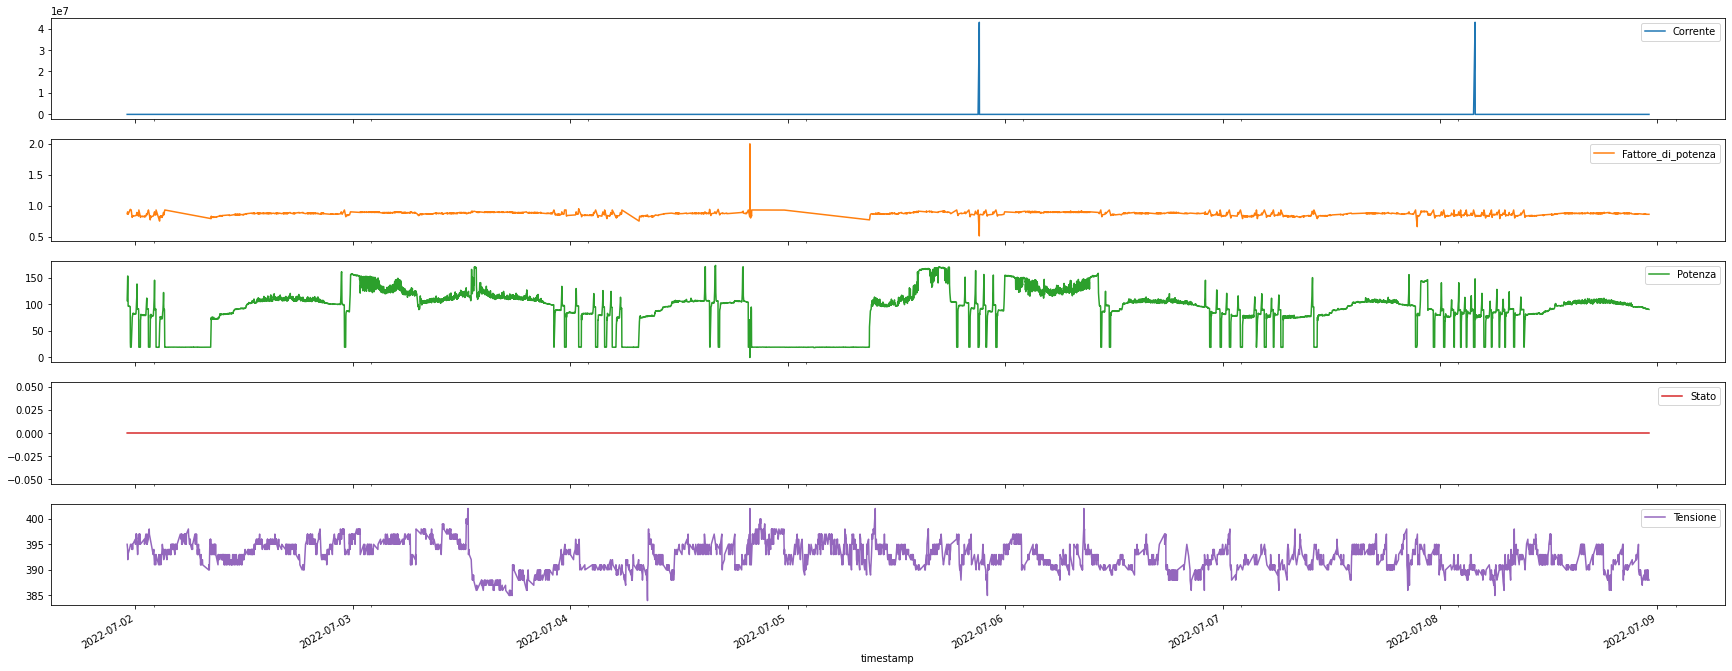

In [ ]:
# For example, we can plot some of these metrics for the given device ('chiller1-1')

%matplotlib inline

metrics = ['Potenza','Fattore_di_potenza','Tensione','Corrente','Stato']

df_list = (sq.SELECT('*')
      .FROM(metric)
      .WHERE(device='chiller1-1')
      .TSTART(7, 'days')
      .AGGRBY('avg', sampling_value=1, sampling_unit='minutes', align_sampling=True)
      .execute().df_table for metric in metrics)

ex.df_table = pd.concat(df_list)
ex.to_series(flat_index=True, interp='time', dropna=True, columns=['name'])
ex.df_ts.plot(figsize=[30,12], subplots=True);

## Schneider
The Schneider plugin is a dedicated data collector designed to acquire data from an industrial PLC by accessing its HMI module (from [Schneider Electric](https://www.se.com/ww/en/product-category/2100-human-machine-interfaces-hmi/)).

The PLC controls the valves and pumps of the liquid cooling circuit (RDHx) of Marconi 100. It consists of two (redundant) twin systems controllable by two identical HMI panels, Q101 and Q102.

The examon plugin extracts and stores all the metrics available on both panels.

In [ ]:
# Query of all metrics collected by the Schneider plugin

df = sq.DESCRIBE(tag_key='plugin', tag_value='schneider_pub') \
    .execute()

display(df)

,name
0,Alm_TY141
1,PLC_PLC_Q101.Abilita_inverter
2,PLC_PLC_Q101.Abilita_valvola1
3,PLC_PLC_Q101.Abilita_valvola2
4,PLC_PLC_Q101.Allarme_on
...,...
159,PLC_PLC_Q101.V_ore_tot_p101
160,PLC_PLC_Q101.V_ore_tot_p102
161,PLC_PLC_Q101.V_ore_tot_p103
162,PLC_PLC_Q101.V_ore_tot_p104


In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='PLC_PLC_Q101.Portata_1_hmi') \
    .execute()

display(df)

,name,tag key,tag values
0,PLC_PLC_Q101.Portata_1_hmi,asset,[pumps]
1,PLC_PLC_Q101.Portata_1_hmi,chnl,[data]
2,PLC_PLC_Q101.Portata_1_hmi,facility,[casalecchio_di_reno]
3,PLC_PLC_Q101.Portata_1_hmi,org,[cineca]
4,PLC_PLC_Q101.Portata_1_hmi,panel,"[Q101, Q102]"
5,PLC_PLC_Q101.Portata_1_hmi,plugin,[schneider_pub]


The tag `panel` is used to distinguish the metrics of the two panels (Q101 and Q102).

## Vertiv
The [Vertiv](https://www.vertiv.com/en-emea/) plugin mainly collects data from the air-conditioning units (CDZ) located in room F (Marconi 100) of Cineca.

The plugin uses the RESTful API interface available on the individual devices to extract the most interesting metrics.

In [ ]:
# Query of all metrics collected by the Vertiv plugin

df = sq.DESCRIBE(tag_key='plugin', tag_value='vertiv_pub') \
    .execute()

display(df)

,name
0,Actual_Return_Air_Temperature_Set_Point
1,Actual_Return_Humidity_Set_Point
2,Adjusted_Humidity
3,Compressor_Utilization
4,Dehumidifier_Utilization
5,Ext_Air_Sensor_A_Humidity
6,Ext_Air_Sensor_A_Temperature
7,Ext_Air_Sensor_B_Humidity
8,Ext_Air_Sensor_B_Temperature
9,Ext_Air_Sensor_C_Humidity


In [ ]:
# Query of all attributes (keys and values) of a specific metric

df = sq.DESCRIBE(metric='Supply_Air_Temperature') \
    .execute()

display(df)

,name,tag key,tag values
0,Supply_Air_Temperature,asset,[CRACs]
1,Supply_Air_Temperature,chnl,[data]
2,Supply_Air_Temperature,device,"[cdz1, cdz2, cdz3, cdz4, cdz5, cdz6]"
3,Supply_Air_Temperature,facility,[casalecchio_di_reno]
4,Supply_Air_Temperature,org,[cineca]
5,Supply_Air_Temperature,plugin,[vertiv_pub]
6,Supply_Air_Temperature,room,[f]
7,Supply_Air_Temperature,units,[?C]


The tag `device` is used to distinguish the metrics of the different CDZs (cdz1-6).






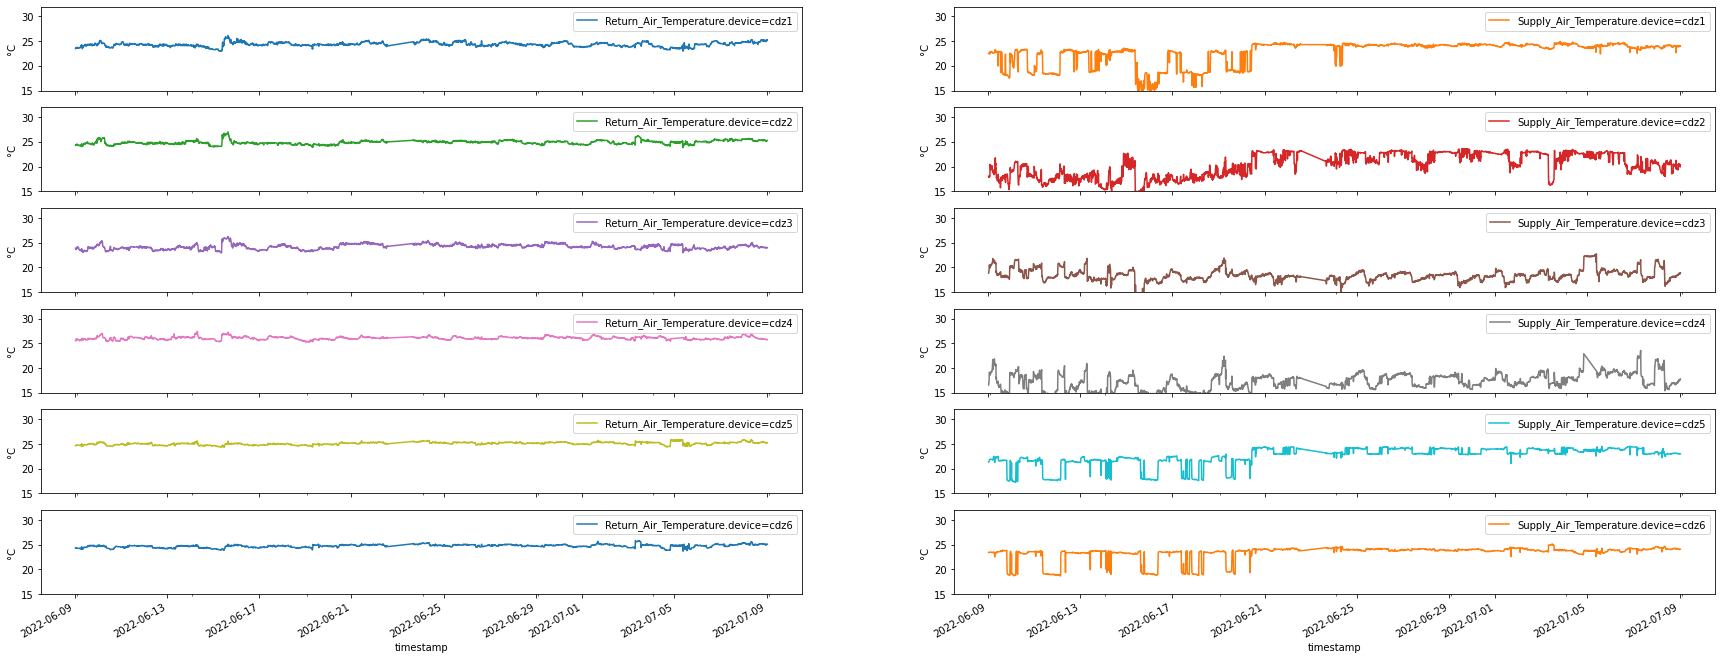

In [ ]:
# For example, we can plot some of these metrics for all the CDZs.

%matplotlib inline

metrics = ['Supply_Air_Temperature','Return_Air_Temperature']

df_list = (sq.SELECT('device')
      .FROM(metric)
      .TSTART(30, 'days')
      .AGGRBY('avg', sampling_value=10, sampling_unit='minutes', align_sampling=True)
      .execute().df_table for metric in metrics)

ex.df_table = pd.concat(df_list)
ex.to_series(flat_index=True, interp='time', dropna=True, columns=['device','name'])
ax = ex.df_ts.plot(figsize=[30,12], subplots=True, layout=(6,2));
for x in ax.reshape(-1):
  x.set_ylim(15, 32)
  x.set_ylabel('°C')



---

